In [3]:
# Placeholder
# Package Load
import numpy as np
import pandas as pd
import argparse
import time
import cv2
from imutils.object_detection import non_max_suppression
import pytesseract
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
def detect_text(img, east, min_confidence=0.5, width = 320, height = 320, padding=0.5):
    # load the input image and grab the image dimensions
    image = img
    orig = image.copy()
    (origH, origW) = image.shape[:2]

    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (width, height)
    rW = origW / float(newW)
    rH = origH / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    # load the pre-trained EAST text detector
    net = east

    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    # show timing information on text prediction
    #print("[INFO] text detection took {:.6f} seconds".format(end - start))

    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < min_confidence:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # A more accurate bounding box for rotated text
            offsetX = offsetX + cos * xData1[x] + sin * xData2[x]
            offsetY = offsetY - sin * xData1[x] + cos * xData2[x]

            # calculate the UL and LR corners of the bounding rectangle
            p1x = -cos * w + offsetX
            p1y = -cos * h + offsetY
            p3x = -sin * h + offsetX
            p3y = sin * w + offsetY

            # add the bounding box coordinates
            rects.append((p1x, p1y, p3x, p3y))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
    #pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/tesseract'
    
    results = []
    
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        # in order to obtain a better OCR of the text we can potentially
        # apply a bit of padding surrounding the bounding box -- here we
        # are computing the deltas in both the x and y directions
        dX = int((endX - startX) * padding)
        dY = int((endY - startY) * padding)

        # apply padding to each side of the bounding box, respectively
        startX = max(0, startX - dX)
        startY = max(0, startY - dY)
        endX = min(origW, endX + (dX * 2))
        endY = min(origH, endY + (dY * 2))
        
        # extract the actual padded ROI
        roi = orig[startY:endY, startX:endX]
        text = ocr_text(img=roi)
        results.append(((startX, startY, endX, endY), text))
        
        
    # sort the results bounding box coordinates from top to bottom
    results = sorted(results, key=lambda r:r[0][1])
    
    for ((startX, startY, endX, endY), text) in results:
        # show the output image
        display_ocr_text(startX, startY, endX, endY, text)


In [18]:
def display_ocr_text(startX, startY, endX, endY, text):    
    # display the text OCR'd by Tesseract
    print("OCR TEXT")
    print("========")
    print("{}\n".format(text))

    # strip out non-ASCII text so we can draw the text on the image
    # using OpenCV, then draw the text and a bounding box surrounding
    # the text region of the input image
    text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
    output = orig.copy()
    cv2.rectangle(output, (startX, startY), (endX, endY), (0, 0, 255), 2)
    cv2.putText(output, text, (startX, startY - 20), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
        
        #Show the image with matplotlib instead to avoid crash
    plt.imshow(output)
    plt.show()
    

In [10]:
def ocr_text(img, language="eng", oem="1", psm="7"):
    # in order to apply Tesseract v4 to OCR text we must supply
    # (1) a language, (2) an OEM flag of 4, indicating that the we
    # wish to use the LSTM neural net model for OCR, and finally
    # (3) an OEM value, in this case, 7 which implies that we are
    # treating the ROI as a single line of text
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
    config = ("-l "+language+" --oem "+oem+" --psm "+psm)
    text = pytesseract.image_to_string(img, config=config)

    # add the bounding box coordinates and OCR'd text to the list
    # of results
    return(text)

In [24]:
workdir = 'C:/Users/David/Desktop/Raspberry_Pi/Projects/Scoreboard/'
image = cv2.imread(workdir+'Images/btn_osu_minn.JPG')
scoreboard = image[910:970, 360:1600]
width_splits = [[0,240], [330, 410], [415, 630], [740, 830], [850, 1000], [1000, 1100], [1110, 1200]]
height_splits = [0,50]
east = cv2.dnn.readNet('frozen_east_text_detection.pb')

text = []

for w in width_splits:
    crop_image = scoreboard[height_splits[0]:height_splits[1], w[0]:w[1]]
    ocrtext = ocr_text(crop_image)
    text.append(ocrtext)

In [25]:
text

['| 3 OHIO STATE', 'A9', 'sei.)', '63', '2nd Half', '7:00', 're']

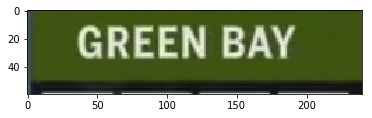

In [21]:
plt.imshow(scoreboard[height_splits[0]:height_splits[1], width_splits[0][0]:width_splits[0][1]])
plt.show()